In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import scipy.signal as signal
from scipy import ndimage
from sklearn.linear_model import RANSACRegressor
from skimage import morphology
import skimage as ski
import cv2
import math

In [2]:
def read_data(m,n,filepath):
	data = pd.read_csv(filepath, delim_whitespace=True, usecols=[0], header=None, skiprows=1)
	mat = np.flip(data.to_numpy().reshape(m, n),axis=0)
	return mat

def gray_img(mat,vmin=-10,vmax=10):
	# plot gray image
	plt.figure(figsize=(12, 12))
	plt.imshow(mat, cmap='gray',vmin=vmin,vmax=vmax)#,vmin=-849, vmax=-611)#
	plt.colorbar()
	plt.title('Gray Scale Image')
	plt.show()

def flatten(mat):
    # fit line
    flat_mat = np.zeros_like(mat)
    x = np.arange(mat.shape[1]).reshape(-1, 1)
    ransac = RANSACRegressor()
    
    for i in range(0, mat.shape[0]):
        ransac.fit(x, mat[i,].reshape(-1, 1))
        slope = ransac.estimator_.coef_
        intercept = ransac.estimator_.intercept_
        y = slope * x + intercept
        flat_mat[i, :] = (mat[i, :] - y.ravel()) 

    # reduce peak
    fstd = flat_mat.std()
    me = np.mean(np.abs(flat_mat[np.abs(flat_mat) < fstd]))
    flat_mat = np.where(flat_mat > 0.8*fstd, me, flat_mat)
    #flat_mat = np.where(flat_mat < -fstd, -me, flat_mat)
                
    return flat_mat




In [3]:
path = "0620S1pA6.021.txt"#"0620S1A1.005.txt" #
n=512
m=475
data = read_data(m,n, path)

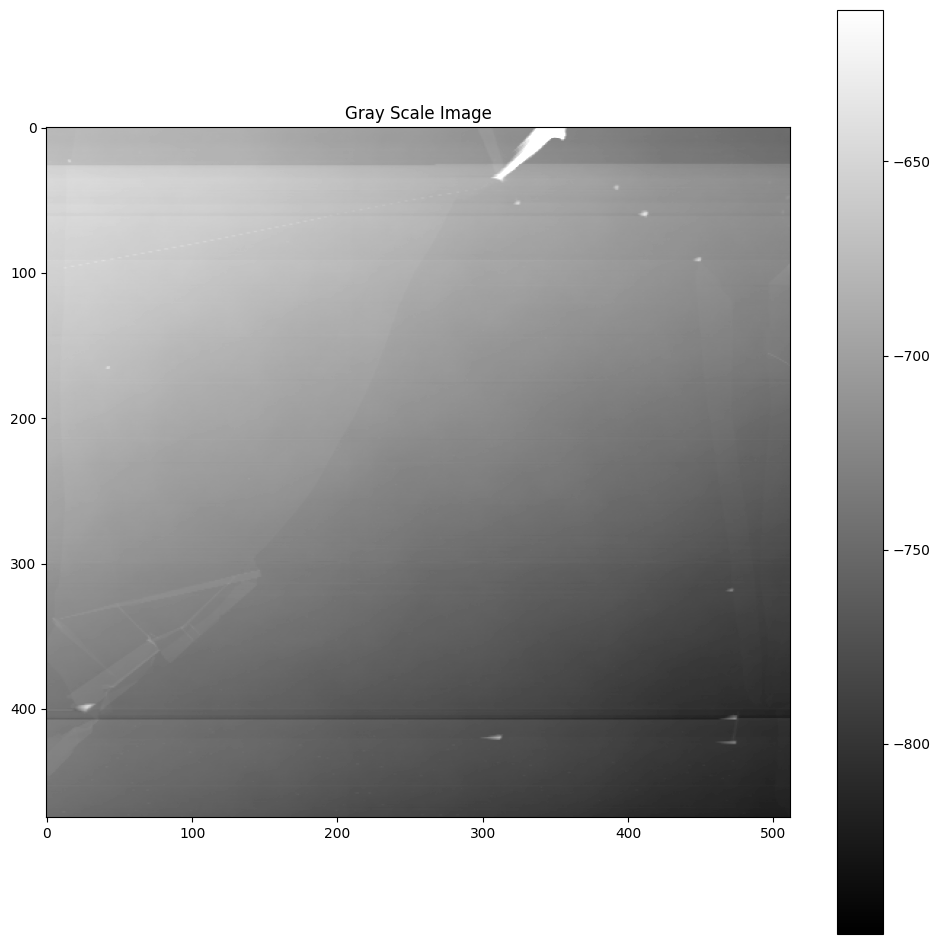

In [4]:
gray_img(data,-849,-611)

In [5]:
# flatten
flatten_data = flatten(data)

In [6]:
# median filter
media_data=signal.medfilt(flatten_data,5)

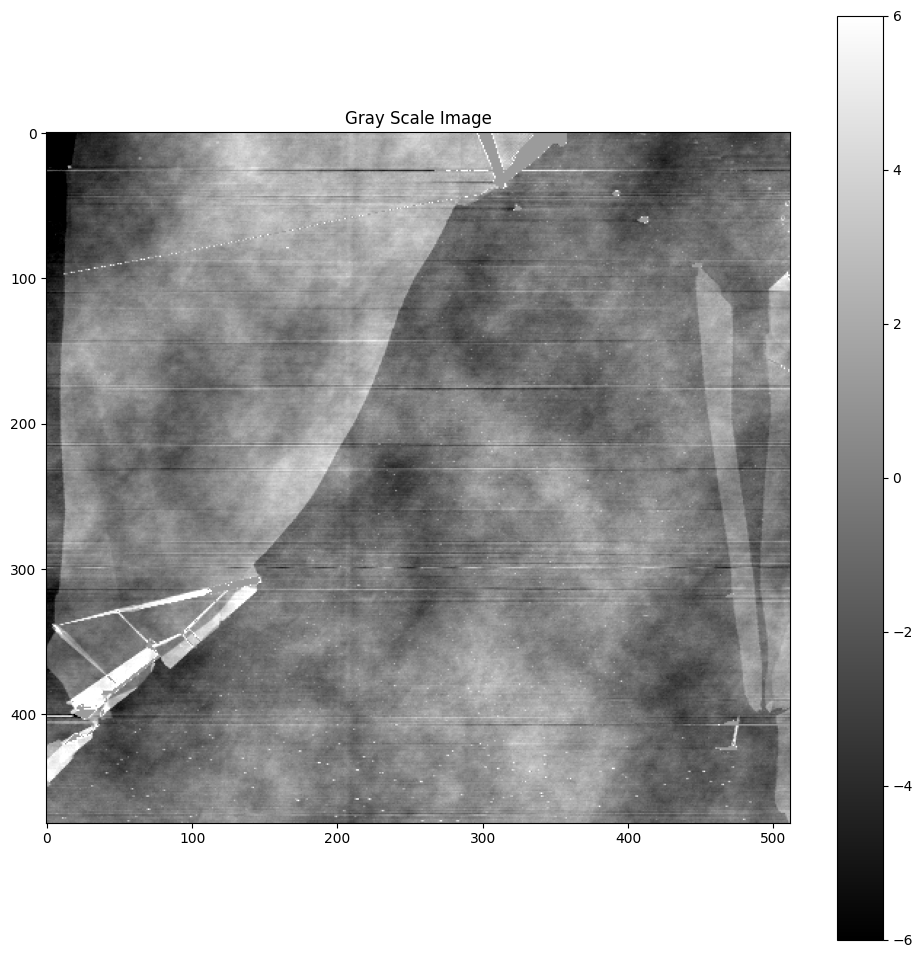

In [7]:
gray_img(flatten_data, -6,6)

In [146]:
np.savetxt("matrix.txt",media_data)

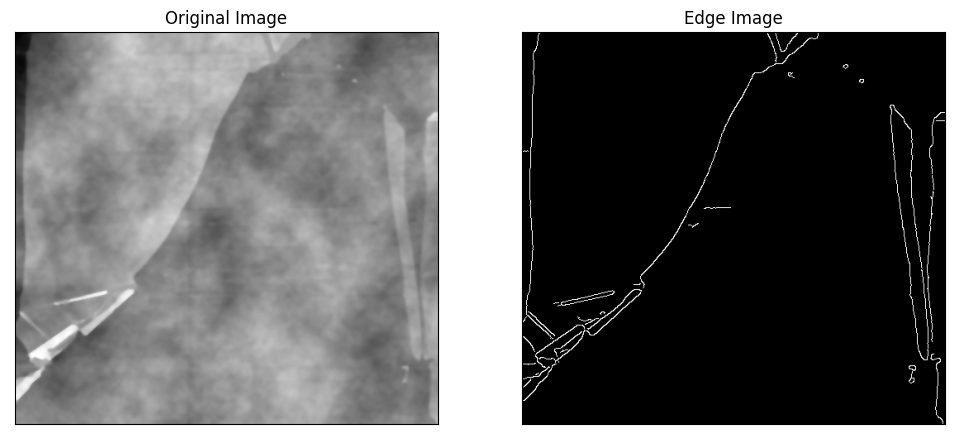

In [78]:
flat_mat = flatten_data
#flat_mat = np.abs(np.diff(flat_mat))
#flat_mat = flat_mat[100:300,]

# zoom the image to 0-255
scaled_image = cv2.normalize(flat_mat, None, 0, 255, cv2.NORM_MINMAX)


# convert into uint8
uint8_image = scaled_image.astype(np.uint8)
media_img=cv2.medianBlur(uint8_image,5)
media_img=cv2.GaussianBlur(media_img,(3,3),0)
media_img=cv2.bilateralFilter(media_img, 5, 25, 25)

# using Canny to detect the boundary
threshold1 = 40  # parameter1
threshold2 = 20  # parameter2
edges = cv2.Canny(media_img, threshold1, threshold2, L2gradient=True)

# visualization
plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(media_img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()


In [116]:
np.savetxt("matrix.txt",media_img)

In [79]:
[row, col] = np.where(edges > 0)
bound = np.zeros_like(data)
bound[row, col] = 1

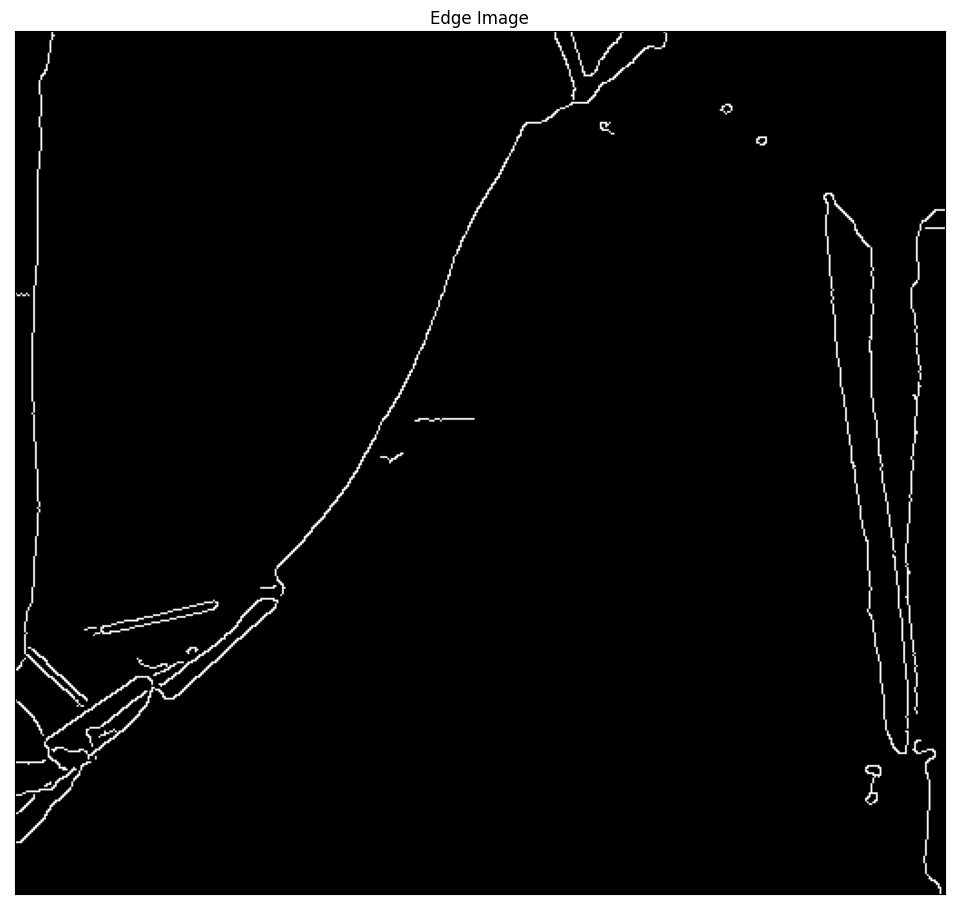

In [80]:
plt.figure(figsize=(12, 12))
plt.imshow(bound, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [85]:
diffb=bound#np.diff(bound)
diffb=np.where(diffb>0,1,0)

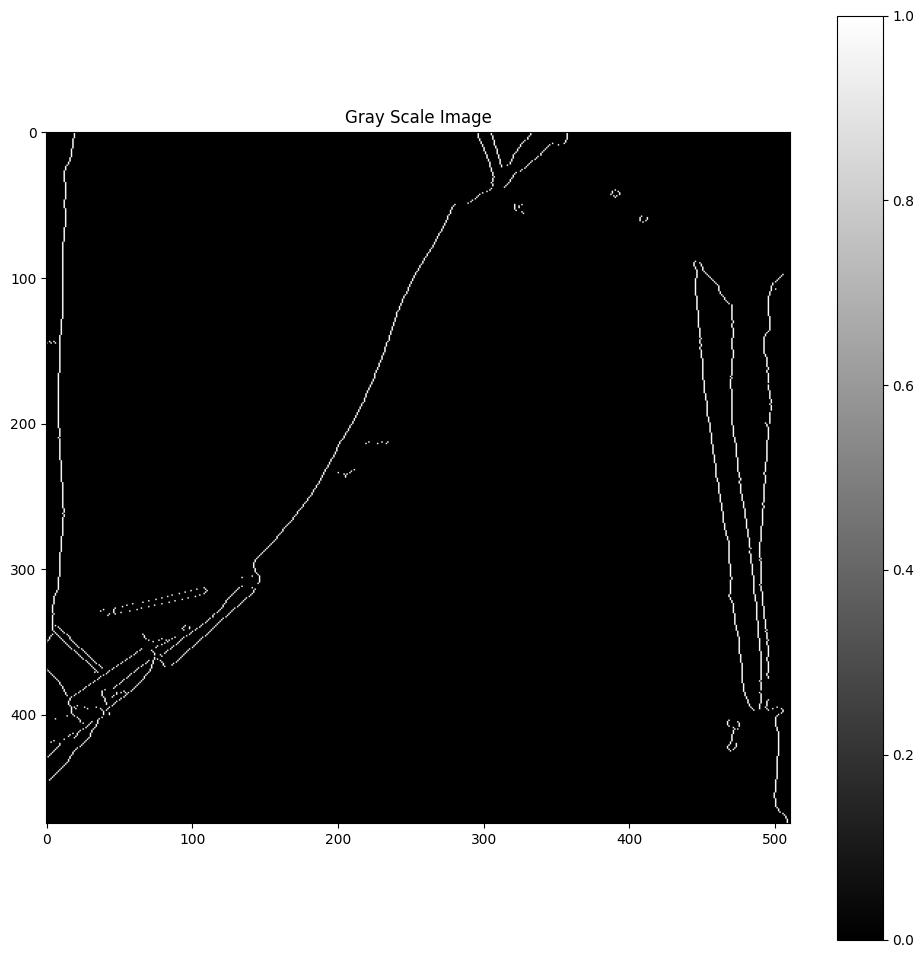

In [82]:
gray_img(diffb,0,1)

In [99]:
clean_img = morphology.remove_small_objects(diffb!=0, min_size=3)

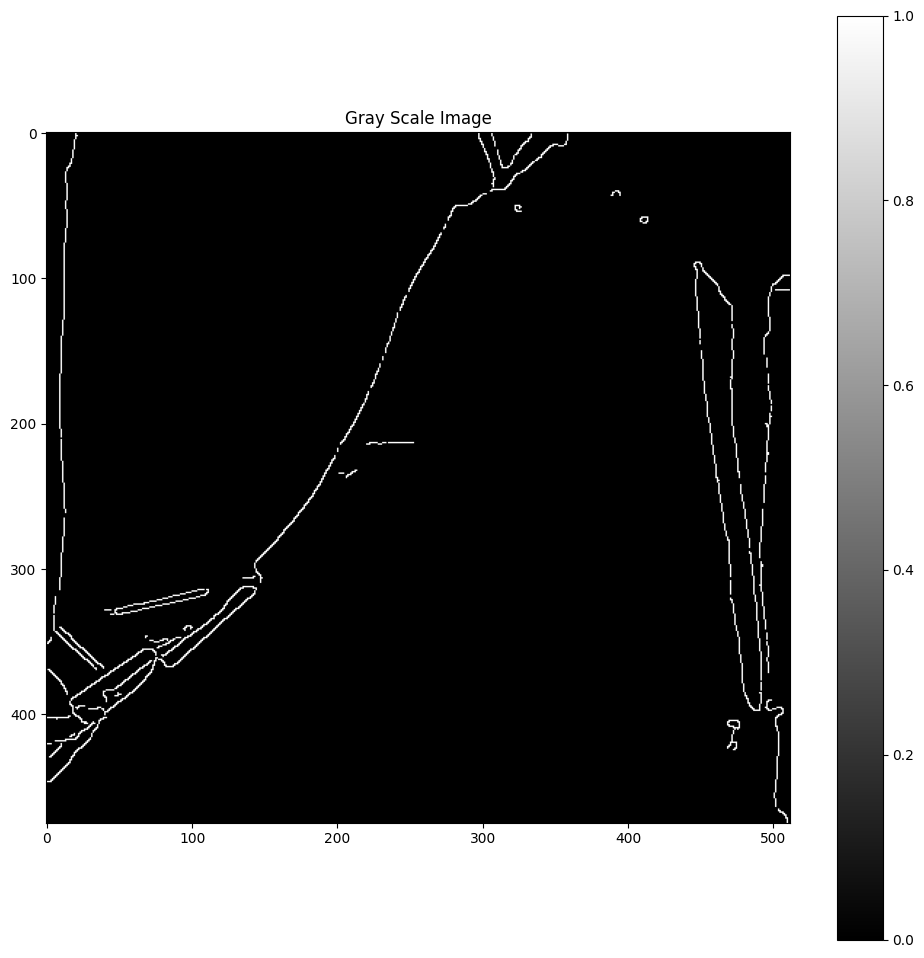

In [100]:
gray_img(clean_img,0,1)

In [35]:
# 3D visualize
temp = bound#clean_img
temp = np.where(temp==1,2,0)
np.savetxt("matrix.txt",temp)

In [113]:
neighborhood = np.array([[1, 1, 1, 1, 1],
                         [1, 1, 1, 1, 1],
                         [1, 1, 1, 1, 1],
                         [1, 1, 1, 1, 1],
                         [1, 1, 1, 1, 1]])

# 执行膨胀操作
dilated_matrix = ndimage.binary_dilation(diffb, structure=neighborhood, iterations=1)

# 找到孤立点并置为0
isolated_points = np.logical_and(diffb == 1, dilated_matrix == 0)
diffb[isolated_points] = 0

In [115]:
np.where(isolated_points!=False)

(array([], dtype=int64), array([], dtype=int64))

In [19]:
print(temp[200,].mean(),temp[200,].std())

-2.9531932455029164e-14 1.1290313078058167


In [66]:
def zero_below_relative_std(row):
    std = np.std(row)
    mean = np.mean(row)
    relative_std = 0.6*(std / mean)
    return np.where(relative_std < row, row, 0)

# 应用自定义函数到每一行
result = np.apply_along_axis(zero_below_relative_std, axis=1, arr=absd)

In [61]:
absd.std()

0.4329318331376845

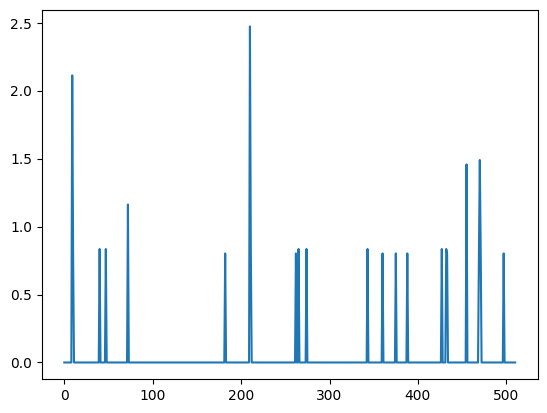

In [68]:
plt.plot(result[200,])
plt.show()

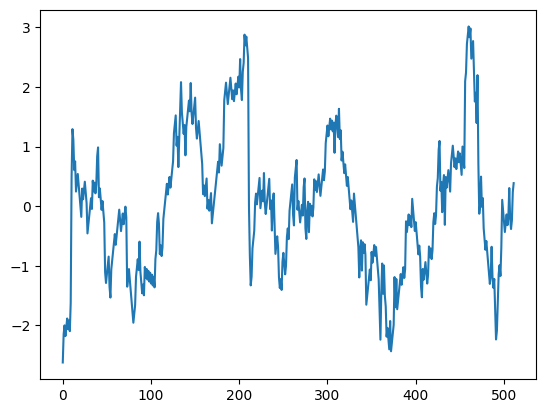

In [27]:
plt.plot(temp[200,])
plt.show()

In [ ]:
# 沿每段拟合